In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/opt/extradata/competitive-data-science-predict-future-sales/"))

items_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/items.csv')
shops_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/shops.csv')

icats_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/item_categories.csv')
train_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/sales_train.csv', header=0, sep=',', quotechar='"')
smpsb_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/sample_submission.csv', header=0, sep=',', quotechar='"')
test_df  = pd.read_csv(r'/opt/extradata/competitive-data-science-predict-future-sales/test.csv', header=0, sep=',', quotechar='"')
# Any results you write to the current directory are saved as output.'''

['item_categories.csv', 'items.csv', 'shops.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'X_train_all.csv', 'y_train_all.csv', 'X_train.csv']


In [4]:
import numpy as np
import time
start_time = time.time()
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import (LinearRegression,SGDRegressor)
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [5]:
l = list(icats_df.item_category_name)
l_cat = l

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


icats_df['cats'] = l_cat
icats_df.head()

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [6]:
items_df = pd.merge(items_df, icats_df, on=['item_category_id'], how='left')
items_df = items_df[['item_id', 'cats']]
items_df.head()

,item_id,cats
0,0,Movie
1,1,Soft
2,2,Movie
3,3,Movie
4,4,Movie


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
print('Do all the shop ids in test data appear in train data?',set(test_df.shop_id.unique()) < set(train_df.shop_id.unique()))
print(test_df.item_id.unique().shape)
print(test_df.shop_id.unique().shape)
assert 5100 * 42 == len(test_df)
print(train_df.item_id.unique().shape)
print('Do all the item ids in test data appear in train data? ',set(test_df.item_id.unique()) < set(train_df.item_id.unique()))

Do all the shop ids in test data appear in train data? True
(5100,)
(42,)
(21807,)
Do all the item ids in test data appear in train data?  False


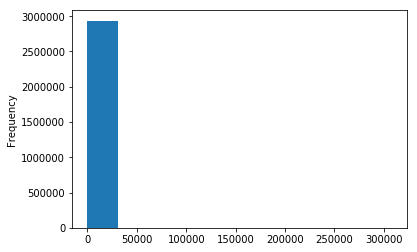

In [8]:
train_df.item_price.plot.hist(bins=10)

In [9]:
# Remove Outliers
train_df = train_df[train_df['item_price'] < 100000]
train_df = train_df[train_df['item_cnt_day'] < 1000]
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935846e+06,2.935846e+06,2.935846e+06,2.935846e+06,2.935846e+06
mean,1.456990e+01,3.300175e+01,1.019722e+04,8.907492e+02,1.241562e+00
std,9.422985e+00,1.622697e+01,6.324297e+03,1.720491e+03,2.217636e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,6.690000e+02


In [10]:
#aggregating data
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []
for block_num in train_df['date_block_num'].unique():
    cur_shops = train_df.loc[train_df['date_block_num'] == block_num,
                             'shop_id'].unique()
    cur_items = train_df.loc[train_df['date_block_num'] == block_num,
                             'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, 
                                        [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

train_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(
    {'item_cnt_day': np.sum, 'item_price': np.mean}).reset_index()

train_df.rename(index=str,columns={'item_cnt_day': 'item_cnt_month'},inplace=True)

train_df = pd.merge(grid, train_df, on=index_cols, how='left')
train_df.describe()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
count,1.091380e+07,1.091380e+07,1.091380e+07,1.609122e+06,1.609122e+06
mean,3.118720e+01,1.130929e+04,1.497336e+01,2.265233e+00,7.906943e+02
std,1.734959e+01,6.209982e+03,9.495635e+00,8.429583e+00,1.532592e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,9.000000e-02
25%,1.600000e+01,5.976000e+03,7.000000e+00,1.000000e+00,1.990000e+02
50%,3.000000e+01,1.139100e+04,1.400000e+01,1.000000e+00,3.990000e+02
75%,4.600000e+01,1.660500e+04,2.300000e+01,2.000000e+00,8.985000e+02
max,5.900000e+01,2.216900e+04,3.300000e+01,1.644000e+03,5.099900e+04


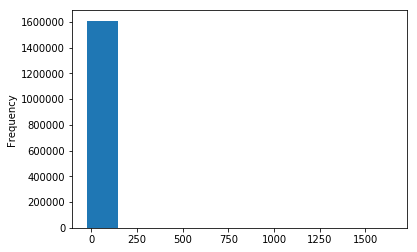

In [11]:
train_df.item_cnt_month.plot.hist()

In [12]:
# Add category id to each data point
train_df = pd.merge(train_df, items_df, on=['item_id'], how='left')
test_df = pd.merge(test_df, items_df, on=['item_id'], how='left')
set(test_df.cats.unique()) < set(train_df.cats.unique())

True

In [13]:
# Mean encoding
for type_ids in [['item_id'], ['shop_id'], ['cats'], ['item_id', 'shop_id']]:
    for column_id in ['item_price', 'item_cnt_month']:
        mean_df = train_df[type_ids + [column_id]].groupby(type_ids).agg(np.mean).reset_index()
        mean_df.rename(
            {column_id: "mean_of_"+column_id+"_groupby_"+"_".join(type_ids)},
            axis='columns', inplace=True
        )
        
        train_df = pd.merge(train_df, mean_df, on=type_ids, how='left')
        test_df = pd.merge(test_df, mean_df, on=type_ids, how='left')

In [14]:
# Fill NA
test_df['mean_of_item_price_groupby_item_id'] = test_df['mean_of_item_price_groupby_item_id'].fillna(test_df['mean_of_item_price_groupby_cats'])
test_df['mean_of_item_cnt_month_groupby_item_id'] = test_df['mean_of_item_cnt_month_groupby_item_id'].fillna(test_df['mean_of_item_cnt_month_groupby_cats'])
test_df['mean_of_item_price_groupby_item_id_shop_id'] = test_df['mean_of_item_price_groupby_item_id_shop_id'].fillna(test_df['mean_of_item_price_groupby_item_id'])
test_df['mean_of_item_cnt_month_groupby_item_id_shop_id'] = test_df['mean_of_item_cnt_month_groupby_item_id_shop_id'].fillna(test_df['mean_of_item_cnt_month_groupby_item_id'])

train_df['mean_of_item_price_groupby_item_id_shop_id'] = train_df['mean_of_item_price_groupby_item_id_shop_id'].fillna(train_df['mean_of_item_price_groupby_item_id'])
train_df['mean_of_item_cnt_month_groupby_item_id_shop_id'] = train_df['mean_of_item_cnt_month_groupby_item_id_shop_id'].fillna(train_df['mean_of_item_cnt_month_groupby_item_id'])

train_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'cats', 'mean_of_item_price_groupby_item_id',
       'mean_of_item_cnt_month_groupby_item_id',
       'mean_of_item_price_groupby_shop_id',
       'mean_of_item_cnt_month_groupby_shop_id',
       'mean_of_item_price_groupby_cats',
       'mean_of_item_cnt_month_groupby_cats',
       'mean_of_item_price_groupby_item_id_shop_id',
       'mean_of_item_cnt_month_groupby_item_id_shop_id'],
      dtype='object')

In [15]:
for df in train_df, test_df:
    for feat in df.columns[4:]:
        if 'item_cnt' in feat:
            df[feat]=df[feat].fillna(0)
        elif 'item_price' in feat:
            df[feat]=df[feat].fillna(df[feat].median())
train_df['item_cnt_month'] = train_df['item_cnt_month'].fillna(0)
train_df.describe()
train_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'cats', 'mean_of_item_price_groupby_item_id',
       'mean_of_item_cnt_month_groupby_item_id',
       'mean_of_item_price_groupby_shop_id',
       'mean_of_item_cnt_month_groupby_shop_id',
       'mean_of_item_price_groupby_cats',
       'mean_of_item_cnt_month_groupby_cats',
       'mean_of_item_price_groupby_item_id_shop_id',
       'mean_of_item_cnt_month_groupby_item_id_shop_id'],
      dtype='object')

In [16]:
# Add previous months sales data
train_df_temp = train_df.copy()
train_df = train_df[train_df['date_block_num']>=12]

features = ['item_cnt_month', 'item_price', 'mean_of_item_price_groupby_item_id',
       'mean_of_item_cnt_month_groupby_item_id',
       'mean_of_item_price_groupby_shop_id',
       'mean_of_item_cnt_month_groupby_shop_id',
       'mean_of_item_price_groupby_cats',
       'mean_of_item_cnt_month_groupby_cats',
       'mean_of_item_price_groupby_item_id_shop_id',
       'mean_of_item_cnt_month_groupby_item_id_shop_id']

def add_historical_data(df):
    for diff in (1, 2, 3, 4, 6, 12):
        train_df_copy = train_df_temp.copy()
        train_df_copy['date_block_num'] += diff
        train_df_copy = train_df_copy[['date_block_num', 'item_id', 'shop_id'] + features]
        train_df_copy.rename({
            feat: feat+"_"+str(diff)+'_month_ago' for feat in features
        }, axis=1, inplace=True)
        df = pd.merge(df, train_df_copy, on=['shop_id', 'item_id', 'date_block_num'], how='left')
    return df

test_df['date_block_num'] = 34
train_df = add_historical_data(train_df)
test_df = add_historical_data(test_df)
test_df.drop('date_block_num', axis=1, inplace=True)

In [17]:
train_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'cats', 'mean_of_item_price_groupby_item_id',
       'mean_of_item_cnt_month_groupby_item_id',
       'mean_of_item_price_groupby_shop_id',
       'mean_of_item_cnt_month_groupby_shop_id',
       'mean_of_item_price_groupby_cats',
       'mean_of_item_cnt_month_groupby_cats',
       'mean_of_item_price_groupby_item_id_shop_id',
       'mean_of_item_cnt_month_groupby_item_id_shop_id',
       'item_cnt_month_1_month_ago', 'item_price_1_month_ago',
       'mean_of_item_price_groupby_item_id_1_month_ago',
       'mean_of_item_cnt_month_groupby_item_id_1_month_ago',
       'mean_of_item_price_groupby_shop_id_1_month_ago',
       'mean_of_item_cnt_month_groupby_shop_id_1_month_ago',
       'mean_of_item_price_groupby_cats_1_month_ago',
       'mean_of_item_cnt_month_groupby_cats_1_month_ago',
       'mean_of_item_price_groupby_item_id_shop_id_1_month_ago',
       'mean_of_item_cnt_month_groupby_item_id_shop

In [18]:
for df in train_df, test_df:
    for feat in train_df.columns[6:]:
        if 'item_cnt' in feat:
            df[feat]=df[feat].fillna(0)
        elif 'item_price' in feat:
            df[feat]=df[feat].fillna(df[feat].median())

In [19]:
# Add pair-difference features
columns = {
    'diff_between_item_shop_and_item': ('mean_of_item_price_groupby_item_id_shop_id', 'mean_of_item_price_groupby_item_id'),
    'diff_between_item_and_category': ('mean_of_item_price_groupby_item_id', 'mean_of_item_price_groupby_cats')
}
for new_feature, (col1, col2) in columns.items():
    for df in (train_df, test_df):
        df[new_feature] = df[col1] - df[col2]


# Clip values of the target
train_df['item_cnt_month'] = train_df['item_cnt_month'].clip(0, 20)

# Split train/valid sets
training_set = train_df[train_df['date_block_num']<33]
validation_set = train_df[train_df['date_block_num']==33].reset_index()

In [19]:
!rm /home/kostya/.kaggle/competitions/competitive-data-science-predict-future-sales/test.csv.gz
!rm /home/kostya/.kaggle/competitions/competitive-data-science-predict-future-sales/sales_train.csv.gz
!rm /home/kostya/.kaggle/competitions/competitive-data-science-predict-future-sales/sample_submission.csv.gz

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
rm: cannot remove '/home/kostya/.kaggle/competitions/competitive-data-science-predict-future-sales/test.csv.gz': No such file or directory
rm: cannot remove '/home/kostya/.kaggle/competitions/competitive-data-science-predict-future-sales/sales_train.csv.gz': No such file or directory
rm: cannot remove '/home/kostya/.kaggle/competitions/competitive-data-science-predict-future-sales/sample_submission.csv.gz': No such file or directory


In [21]:
# Keep useful columns and save them to csv files
features = train_df.columns[6:].tolist()

#train_df[features].to_csv('/opt/extradata/X_train_all.csv', index=False)
#train_df['item_cnt_month'].to_csv('/opt/extradata/y_train_all.csv', index=False)
X_train = training_set[features]
#X_train.to_csv('/opt/extradata/X_train.csv', index=False)


In [22]:
y_train = training_set['item_cnt_month']
#y_train.to_csv('/opt/extradata/y_train.csv', index=False)
X_validation = validation_set[features]
#X_validation.to_csv('/opt/extradata/X_validation.csv', index=False)
y_validation = validation_set['item_cnt_month']
#y_validation.to_csv('/opt/extradata/y_validation.csv', index=False)
test_df = test_df[['ID'] + features]
#test_df.to_csv('/opt/extradata/X_test.csv', index=False)

In [23]:
import xgboost as xgb

params = {
        'eta': 0.08, #best 0.08
        'max_depth': 7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1,
        'silent': True
    }
X_test = test_df[features]

watchlist = [
    (xgb.DMatrix(data=X_train, label=y_train), 'train'),
    (xgb.DMatrix(data=X_validation, label=y_validation), 'validation')
]
model = xgb.train(params, xgb.DMatrix(data=X_train,label= y_train,missing=-999), 500,  watchlist,
                  maximize=False, verbose_eval=5, early_stopping_rounds=50)

[0]	train-rmse:1.15492	validation-rmse:1.10743
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[5]	train-rmse:0.971898	validation-rmse:0.922151
[10]	train-rmse:0.874083	validation-rmse:0.831444
[15]	train-rmse:0.823044	validation-rmse:0.791707
[20]	train-rmse:0.793371	validation-rmse:0.771317
[25]	train-rmse:0.77546	validation-rmse:0.760469
[30]	train-rmse:0.763586	validation-rmse:0.751787
[35]	train-rmse:0.755116	validation-rmse:0.74724
[40]	train-rmse:0.748293	validation-rmse:0.747446
[45]	train-rmse:0.742555	validation-rmse:0.746655
[50]	train-rmse:0.738189	validation-rmse:0.745625
[55]	train-rmse:0.73486	validation-rmse:0.745852
[60]	train-rmse:0.731731	validation-rmse:0.745471
[65]	train-rmse:0.728801	validation-rmse:0.745955
[70]	train-rmse:0.725966	validation-rmse:0.746131
[75]	train-rmse:0.723056	validation-rmse:0.74522
[80]	train-rmse:0.720602	validation-rmse:0.744857
[85

In [24]:
# Stacking
X_train_new = X_train.copy()
X_validation_new = X_validation.copy()
X_test_new = X_test.copy()

params1 = {
        'eta': 0.08, #best 0.08
        'max_depth': 7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1,
        'silent': True
    }
params2 = {
        'eta': 0.08, #best 0.08
        'max_depth': 8,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 4,
        'gamma':1,
        'silent': True
    }
params3 = {
        'eta': 0.08, #best 0.08
        'max_depth': 6,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 5,
        'gamma':1,
        'silent': True
    }
watchlist = [
    (xgb.DMatrix(X_train, y_train), 'train'),
    (xgb.DMatrix (X_validation, y_validation), 'validation')
]
for i, params in enumerate([params1, params2, params3]):
    model = xgb.train(params, xgb.DMatrix(X_train, y_train,missing=-999), 500, 
                      watchlist, maximize=False, verbose_eval=50, 
                      early_stopping_rounds=50)
    X_train_new['xgboost_item_cnt_month_'+str(i)] = model.predict(xgb.DMatrix(X_train),
                                                                  ntree_limit=model.best_ntree_limit)
    X_validation_new['xgboost_item_cnt_month_'+str(i)] = model.predict(xgb.DMatrix(X_validation),
                                                                       ntree_limit=model.best_ntree_limit)
    X_test_new['xgboost_item_cnt_month_'+str(i)] = model.predict(xgb.DMatrix(X_test), 
                                                                 ntree_limit=model.best_ntree_limit)

[0]	train-rmse:1.15492	validation-rmse:1.10743
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.738189	validation-rmse:0.745625
[100]	train-rmse:0.713327	validation-rmse:0.743669
[150]	train-rmse:0.701082	validation-rmse:0.742585
Stopping. Best iteration:
[145]	train-rmse:0.702122	validation-rmse:0.74201

[0]	train-rmse:1.1521	validation-rmse:1.10366
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.719464	validation-rmse:0.739758
[100]	train-rmse:0.693261	validation-rmse:0.742619
Stopping. Best iteration:
[50]	train-rmse:0.719464	validation-rmse:0.739758

[0]	train-rmse:1.15863	validation-rmse:1.116
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 5

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
X_train_sample, _, y_train_sample, __ = train_test_split(X_train, y_train, train_size=.05, random_state=10)
scaler = MinMaxScaler()
scaler.fit(X_train_sample)
for k in (2, 3, 4):
    print("Training model "+str(k))
    neigh = KNeighborsRegressor(n_neighbors=k, n_jobs=-1, algorithm='kd_tree')
    neigh.fit(scaler.transform(X_train_sample), y_train_sample)
    print("Using "+str(k)+" to predict")
    X_train_new[str(k)+'_neighbors'] = neigh.predict(scaler.transform(X_train))
    X_validation_new[str(k)+'_neighbors'] = neigh.predict(scaler.transform(X_validation))
    X_test_new[str(k)+'_neighbors'] = neigh.predict(scaler.transform(X_test))

Training model 2
Using 2 to predict
Training model 3
Using 3 to predict
Training model 4
Using 4 to predict


In [26]:
X_train = X_train_new
X_validation = X_validation_new
X_test = X_test_new

In [27]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1, copy_X=True, normalize=True, max_iter=1000)
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_validation, model.predict(X_validation)))

0.532745148051867


In [28]:
smpsb_df.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [29]:
pred = model.predict(X_test)

In [30]:
smpsb_df['item_cnt_month']=pred.clip(0,40)

In [31]:
smpsb_df.head()

,ID,item_cnt_month
0,0,0.746847
1,1,0.287258
2,2,1.030575
3,3,0.204061
4,4,0.075939


In [32]:
smpsb_df.to_csv('/home/kostya/.kaggle/submission_stack.csv',index=False)

In [34]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission_stack.csv -m "3XGB+KNN+Ridge"

Traceback (most recent call last):
  File "/home/kostya/anaconda3/bin/kaggle", line 11, in <module>
    sys.exit(main())
  File "/home/kostya/anaconda3/lib/python3.5/site-packages/kaggle/cli.py", line 48, in main
    out = args.func(**command_args)
  File "/home/kostya/anaconda3/lib/python3.5/site-packages/kaggle/api/kaggle_api_extended.py", line 221, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message, competition, quiet)
  File "/home/kostya/anaconda3/lib/python3.5/site-packages/kaggle/api/kaggle_api_extended.py", line 202, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/home/kostya/anaconda3/lib/python3.5/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'submission_stack.csv'
